# Looking closely at SHAP

## KernalExplainer

**A unified measure of feature importance.**

William Harding william.harding@avanade.com </br>
Manager, Advanced Analytics</br>
Data and AI COE</br>

In [1]:
#standards
import pandas as pd
import numpy as np
import altair as alt
import IPython

#warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

#stats
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier

#Shap
import shap
shap.initjs()

#datasets
from sklearn import datasets
iris = datasets.load_iris()

ImportError: Can't determine version for bottleneck

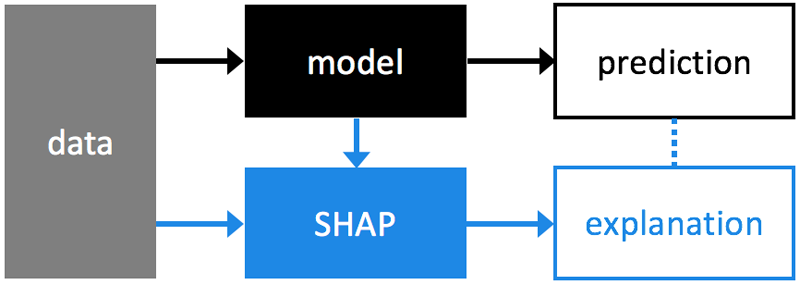

In [2]:
IPython.display.Image(filename='images/shap_diagram.png')

# Looking at the IRIS Dataset

In [3]:
print(datasets.load_iris()['DESCR'])

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

In [4]:
b_x = pd.DataFrame(iris['data'],
                columns=iris['feature_names'])

b_y = pd.DataFrame(iris['target'],
                  columns=['class'])
b = pd.concat([b_x,b_y],axis=1)

In [5]:
b['class'] = b['class'].apply(lambda x: iris['target_names'][x])

In [6]:
b.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),class
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


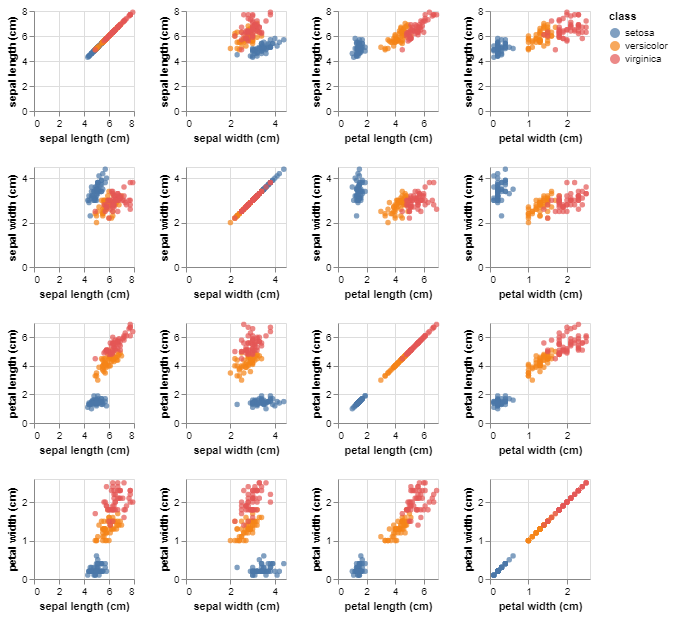

In [7]:
alt.Chart(b).mark_circle().encode(
    alt.X(alt.repeat("column"), type='quantitative'),
    alt.Y(alt.repeat("row"), type='quantitative'),
    color='class'
).properties(
    width=100,
    height=100
).repeat(
    row=list(b_x.columns),
    column=list(b_x.columns)
)

In [8]:
dec = DecisionTreeClassifier().fit(b_x, b_y)
print("the coefficient of determination R^2 of the prediction: ",dec.score(b_x, b_y))

the coefficient of determination R^2 of the prediction:  1.0


## SHAP Values

Kernel SHAP [KernalExplainer](https://github.com/slundberg/shap/blob/5b2b749afbcde74e50eba0c8cc1983c35b331e53/shap/explainers/kernel.py) uses a specially-weighted local linear regression to estimate SHAP values for any model.

In [9]:
explainer = shap.KernelExplainer(dec.predict_proba, b_x, feature_dependence="independent")
shap_values = explainer.shap_values(b_x)

Using 150 background data samples could cause slower run times. Consider using shap.kmeans(data, K) to summarize the background as K weighted samples.


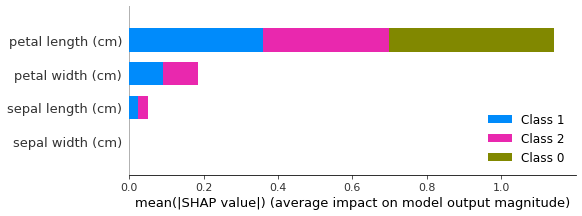

In [10]:
shap.summary_plot(shap_values, b_x)

In [11]:
def f(x):
    if x=='setosa':
        return 1
    else:
        return 0

b_x1 = b_x.copy()
b_x1['class'] = b['class'].apply(f)
b_x1.groupby('class').mean()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
class,,,,
0,6.262,2.872,4.906,1.676
1,5.006,3.428,1.462,0.246


In [12]:
shaps = [pd.DataFrame(i,columns=b_x.columns) for i in explainer.attributions(b_x)]

In [13]:
print([(i,iris['target_names'][i]) for i in range(3)])

[(0, 'setosa'), (1, 'versicolor'), (2, 'virginica')]


In [14]:
shaps[0].head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,0.0,0.0,0.666667,0.0
1,0.0,0.0,0.666667,0.0
2,0.0,0.0,0.666667,0.0
3,0.0,0.0,0.666667,0.0
4,0.0,0.0,0.666667,0.0


In [15]:
shaps[1].head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,0.004444,0.0,-0.348889,0.011111
1,0.004444,0.0,-0.348889,0.011111
2,0.004444,0.0,-0.348889,0.011111
3,0.004444,0.0,-0.348889,0.011111
4,0.004444,0.0,-0.348889,0.011111


In [16]:
shaps[0].head().mean()

sepal length (cm)    0.000000
sepal width (cm)     0.000000
petal length (cm)    0.666667
petal width (cm)     0.000000
dtype: float64

In [17]:
shaps[1].head().mean()

sepal length (cm)    0.004444
sepal width (cm)     0.000000
petal length (cm)   -0.348889
petal width (cm)     0.011111
dtype: float64

In [18]:
shaps[1].head().mean().sum()

-0.3333333333333331

In [19]:
shaps[2].head().mean().sum()

-0.333333333333333

In [20]:
b_x2 = b_x.copy().rename(
    columns={c: "v_"+c for c in b_x.columns}
).merge(
    shaps[0].copy().rename(columns={c: "s_"+c for c in shaps[0].columns}),
    left_index=True,right_index=True
)
b_x2['class'] = b['class']

b_x2.head()

,v_sepal length (cm),v_sepal width (cm),v_petal length (cm),v_petal width (cm),s_sepal length (cm),s_sepal width (cm),s_petal length (cm),s_petal width (cm),class
0,5.1,3.5,1.4,0.2,0.0,0.0,0.666667,0.0,setosa
1,4.9,3.0,1.4,0.2,0.0,0.0,0.666667,0.0,setosa
2,4.7,3.2,1.3,0.2,0.0,0.0,0.666667,0.0,setosa
3,4.6,3.1,1.5,0.2,0.0,0.0,0.666667,0.0,setosa
4,5.0,3.6,1.4,0.2,0.0,0.0,0.666667,0.0,setosa


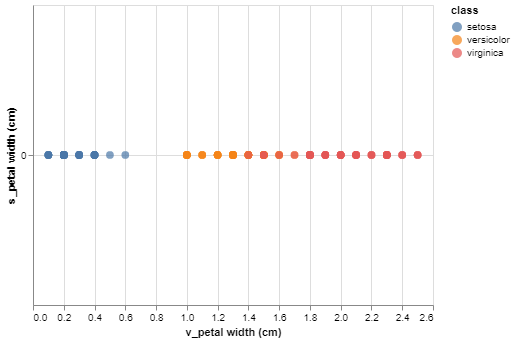

In [21]:
alt.Chart(b_x2).mark_circle(size=60).encode(
    x='v_petal width (cm)',
    y='s_petal width (cm)',
        color='class'
).interactive()

In [22]:
b_x3 = b_x.copy().rename(
    columns={c: "v_"+c for c in b_x.columns}
).merge(
    shaps[1].copy().rename(columns={c: "s_"+c for c in shaps[1].columns}),
    left_index=True,right_index=True
)
b_x3['class'] = b['class']

b_x3.head()

,v_sepal length (cm),v_sepal width (cm),v_petal length (cm),v_petal width (cm),s_sepal length (cm),s_sepal width (cm),s_petal length (cm),s_petal width (cm),class
0,5.1,3.5,1.4,0.2,0.004444,0.0,-0.348889,0.011111,setosa
1,4.9,3.0,1.4,0.2,0.004444,0.0,-0.348889,0.011111,setosa
2,4.7,3.2,1.3,0.2,0.004444,0.0,-0.348889,0.011111,setosa
3,4.6,3.1,1.5,0.2,0.004444,0.0,-0.348889,0.011111,setosa
4,5.0,3.6,1.4,0.2,0.004444,0.0,-0.348889,0.011111,setosa


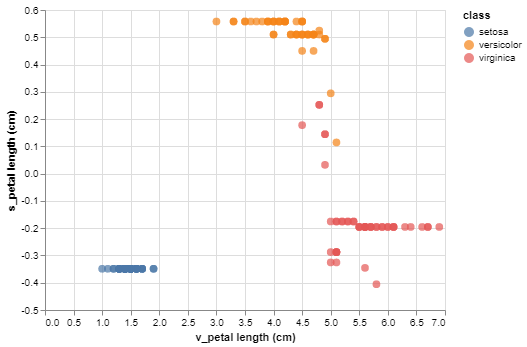

In [23]:
alt.Chart(b_x3).mark_circle(size=60).encode(
    x='v_petal length (cm)',
    y='s_petal length (cm)',
        color='class'
).interactive()

## Example of two predictions.


In [24]:
examples = [4,50]

In [25]:
b.loc[examples]

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),class
4,5.0,3.6,1.4,0.2,setosa
50,7.0,3.2,4.7,1.4,versicolor


In [26]:
b_x.loc[examples]

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
4,5.0,3.6,1.4,0.2
50,7.0,3.2,4.7,1.4


In [27]:
shaps[0].loc[examples]

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
4,0.0,0.0,0.666667,0.0
50,0.0,0.0,-0.333333,0.0


In [28]:
shaps[1].loc[examples]

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
4,0.004444,0.0,-0.348889,0.011111
50,-0.010000,0.0,0.510000,0.166667


In [29]:
explainer.expected_value

array([0.33333333, 0.33333333, 0.33333333])

In [30]:
dec.predict(b_x.loc[examples])

array([0, 1])

In [31]:
explanations = explainer.explain(b_x.loc[examples].values).T
s = explanations[0].shape
pd.DataFrame(explanations)

,0,1,2,3
0,0.000000,0.0,0.666667,0.000000
1,0.004444,0.0,-0.348889,0.011111
2,-0.004444,0.0,-0.317778,-0.011111


In [32]:
examples

[4, 50]

In [33]:
explanations

array([[ 0.        ,  0.        ,  0.66666667,  0.        ],
       [ 0.00444444,  0.        , -0.34888889,  0.01111111],
       [-0.00444444,  0.        , -0.31777778, -0.01111111]])

# Let's make some SHAP values by hand. 

In [34]:
data = b_x.loc[0:1, :]

In [35]:
data

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2


The First step is to work out the amount over / under the mean for each value in the dataset. 

In [36]:
b_x1.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),class
0,5.1,3.5,1.4,0.2,1
1,4.9,3.0,1.4,0.2,1
2,4.7,3.2,1.3,0.2,1
3,4.6,3.1,1.5,0.2,1
4,5.0,3.6,1.4,0.2,1


In [37]:
x = b_x1[iris['feature_names']]
y = b_x1['class']

[Estimated coefficients](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)
for the linear regression problem.

In [38]:
b_x1.groupby('class').mean()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
class,,,,
0,6.262,2.872,4.906,1.676
1,5.006,3.428,1.462,0.246


In [39]:
x.mean()

sepal length (cm)    5.843333
sepal width (cm)     3.057333
petal length (cm)    3.758000
petal width (cm)     1.199333
dtype: float64

In [40]:
(x - x.mean()).head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,-0.743333,0.442667,-2.358,-0.999333
1,-0.943333,-0.057333,-2.358,-0.999333
2,-1.143333,0.142667,-2.458,-0.999333
3,-1.243333,0.042667,-2.258,-0.999333
4,-0.843333,0.542667,-2.358,-0.999333


In [41]:
reg = LinearRegression().fit(x, y)
print("the coefficient of determination R^2 of the prediction: ",reg.score(x, y))

the coefficient of determination R^2 of the prediction:  0.9079951375776257


In [42]:
pd.DataFrame(reg.coef_,index=x.columns)

,0
sepal length (cm),0.066030
sepal width (cm),0.242848
petal length (cm),-0.224657
petal width (cm),-0.057473


Actual shap scores go through a **LOT** of conditional transformations before they are releases. I'm oversimplifying for sure. However as you can see the resulting table is a close proximity to the table produced by SHAP.  

In [43]:
((b_x - b_x.mean()) * reg.coef_).head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,-0.049082,0.107501,0.529741,0.057434
1,-0.062288,-0.013923,0.529741,0.057434
2,-0.075494,0.034646,0.552207,0.057434
3,-0.082097,0.010362,0.507276,0.057434
4,-0.055685,0.131785,0.529741,0.057434


In [44]:
shaps[0].head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,0.0,0.0,0.666667,0.0
1,0.0,0.0,0.666667,0.0
2,0.0,0.0,0.666667,0.0
3,0.0,0.0,0.666667,0.0
4,0.0,0.0,0.666667,0.0


For more input on the the [kerynelExplainer in the source code](https://github.com/slundberg/shap/blob/5b2b749afbcde74e50eba0c8cc1983c35b331e53/shap/explainers/kernel.py)